In [1]:
suppressMessages(library(igraph))
suppressMessages(library(ggnetwork))
library(tidygraph)
library(tidyverse)
library(cowplot)
library(martini)
library(blur)
library(magrittr)
library(patchwork)

theme_set(theme_cowplot())
results <- '../results/'

gene2snp <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = "cc")
snp_assoc <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv')) %>%
    select(SNP,P) %>%
    rename(snp = SNP, p = P)

method_summary <- function(graph) {
    
    tibble(`# nodes` = length(V(graph)),
           `# edges` = length(E(graph)),
           `# subnetworks` = as_tibble(graph) %>% .$module %>% unique %>% na.omit %>% length,
           `Median betweenness` = mean(as_tibble(graph) %>% .$betweenness, na.rm = T) %>% formatC(format = "e", digits = 2),
           `Median SNP P-value` = median(as_tibble(graph) %>% .$p, na.rm = T) %>% format(digits = 2))
    
}


Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        masks tidygraph::groups(), igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default gg

In [2]:
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli")
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli")
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli")

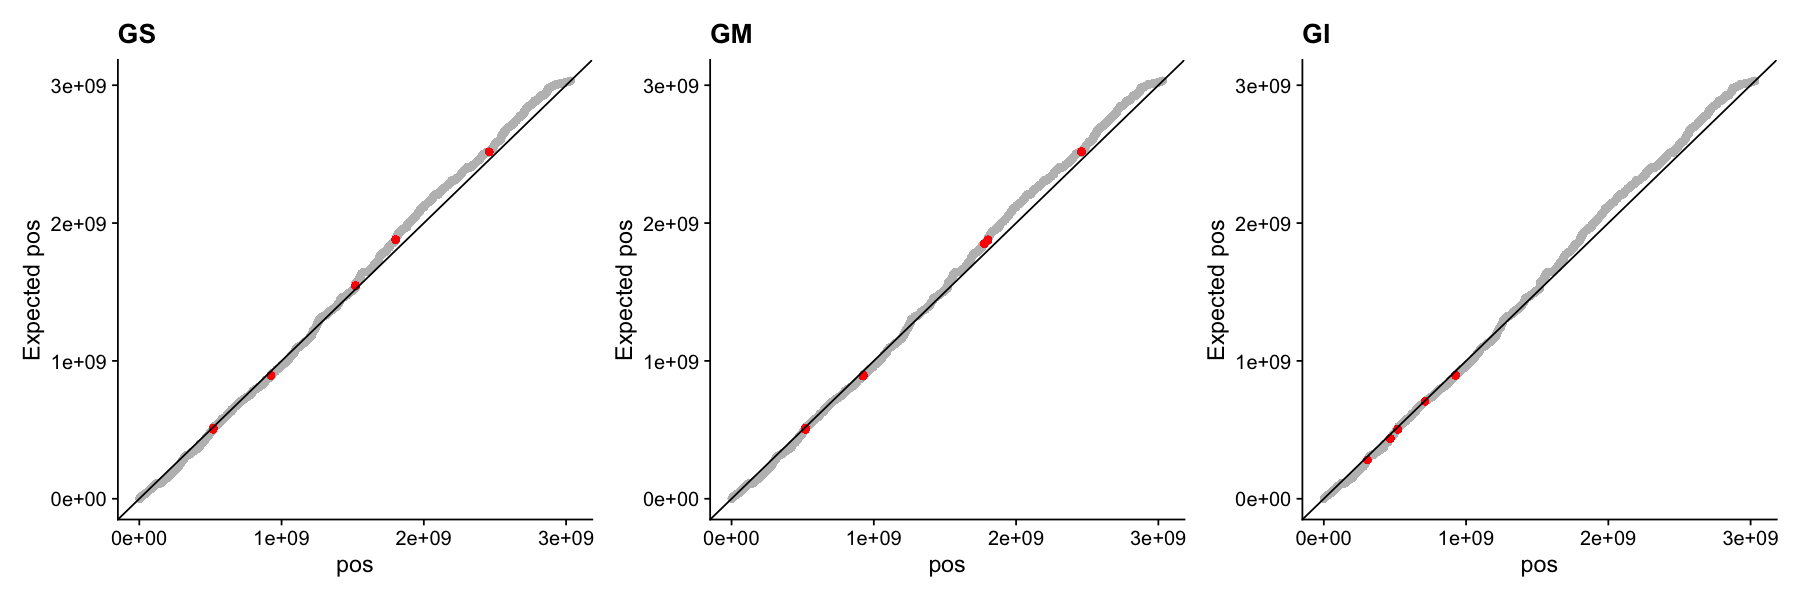

In [3]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
    set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
    select(-cm, -x1, -x2)

rank_map <- map %>%
    # Compute chromosome size
    group_by(chr) %>% 
    summarise(chr_len=max(pos)) %>% 

    # Calculate cumulative position of each chromosome
    mutate(tot=cumsum(chr_len)-chr_len) %>%
    select(-chr_len) %>%
    
    left_join(map, ., by='chr') %>%

    # Add a cumulative position of each SNP
    arrange(chr, pos) %>%
    mutate(BPcum=pos+tot,
           exp_BPcum = seq(min(BPcum), max(BPcum), (max(BPcum) - min(BPcum)) / (n() - 1) ))

plot_density <- function(cones, tag) {
    
    snps <- mutate(rank_map, selected = ifelse(snp %in% cones$snp[cones$selected], 'Yes', 'No'))
    
    ggplot() + 
        geom_point(data = filter(snps, selected == 'No'), aes(x = BPcum, y = exp_BPcum, color = selected)) +
        geom_point(data = filter(snps, selected == 'Yes'), aes(x = BPcum, y = exp_BPcum, color = selected)) +
        geom_abline(slope = 1) +
        scale_color_manual(values = c('Yes' = 'red', 'No' = 'gray')) +
        labs(x = 'pos', y = 'Expected pos', title = tag) +
        theme(legend.position = 'none')
}

options(repr.plot.width=15, repr.plot.height=5)
plot_density(gs, 'GS') + plot_density(gm, 'GM') + plot_density(gi, 'GI') 

In [4]:
# # gs
# load(paste0(results,'scones/gs_network.RData'))

# gs_net <- as_tbl_graph(net) %>%
#     mutate(betweenness = centrality_betweenness()) %>% # 
#     inner_join(snp_assoc, 
#                by = c('name' = 'snp')) %>%
#     inner_join(select(gs, snp, selected, module), 
#                by = c('name' = 'snp'))
    
# save(gs_net, file = paste0(results,'scones/gs_network.betweenness.RData'))
# rm(net)

load(paste0(results,'scones/gs_network.betweenness.RData'))

In [5]:
# # gm
# load(paste0(results,'scones/gm_network.RData'))

# gm_net <- as_tbl_graph(net) %>%
#     mutate(betweenness = centrality_betweenness()) %>%
#     inner_join(snp_assoc, 
#                by = c('name' = 'snp')) %>%
#     inner_join(select(gm, snp, selected, module), 
#                by = c('name' = 'snp'))
# save(gm_net, file = paste0(results,'scones/gm_network.betweenness.RData'))
# rm(net)

load(paste0(results,'scones/gm_network.betweenness.RData'))

In [6]:
# # gi
# load(paste0(results,'scones/gi_network.RData'))

# gi_net <- as_tbl_graph(net) %>%
#     mutate(betweenness = NA) %>% # centrality_betweenness()
#     inner_join(snp_assoc, 
#                by = c('name' = 'snp')) %>%
#     inner_join(select(gi, snp, selected, module), 
#                by = c('name' = 'snp'))
# save(gi_net, file = paste0(results,'scones/gi_network.betweenness.RData'))
# rm(net)

load(paste0(results,'scones/gi_network.betweenness.RData'))

In [7]:
gs_selected_net <- gs_net %>%
    filter(selected)
gm_selected_net <- gm_net %>%
    filter(selected)
gi_selected_net <- gi_net %>%
    filter(selected)

bind_rows(mutate(method_summary(gs_net), Method = 'GS'),
          mutate(method_summary(gs_selected_net), Method = 'SConES GS'),
          mutate(method_summary(gm_net), Method = 'GM'),
          mutate(method_summary(gm_selected_net), Method = 'SConES GM'),
          mutate(method_summary(gi_net), Method = 'GI'),
          mutate(method_summary(gi_selected_net), Method = 'SConES GI')) %>%
    select(Method, everything())

Method,# nodes,# edges,# subnetworks,Median betweenness,Median SNP P-value
<chr>,<int>,<int>,<int>,<chr>,<chr>
GS,197083,197060,5,2.03e+07,0.49
SConES GS,1590,1585,5,2.52e+07,0.023
GM,197083,6442446,5,3.99e+06,0.49
SConES GM,1692,177611,5,4.40e+06,0.055
GI,197083,28733720,5,1.46e+06,0.49
SConES GI,408,539,5,9.33e+06,0.076


In [8]:
set_gs <- gs$snp[gs$selected]
set_gm <- gm$snp[gm$selected]
set_gi <- gi$snp[gi$selected]

length(intersect(set_gs, set_gm))/length(union(set_gs, set_gm))
length(intersect(set_gi, set_gs))/length(union(set_gi, set_gs))
length(intersect(set_gi, set_gm))/length(union(set_gi, set_gm))

[1] 0.5688337

[1] 0.1243669

[1] 0.1176158

# Genes mapped

In [9]:
table_regions(gs, gene2snp)

region,module,coords,bestSnp,genes,numSnps
<chr>,<int>,<chr>,<chr>,<chr>,<chr>
3p24.1,1,27038340-27602278,rs6779140,"NEK10,MICOS10P3,RNU6-342P,SLC4A7,RPS20P15,RNU1-96P",690 (111)
5p12,2,44632008-45094503,rs930395,"LINC02224,RN7SL383P,MRPS30-DT,MRPS30",258 (111)
8q24.21,3,128309591-128442944,rs9693995,"CASC8,POU5F1B,PCAT1,CCAT2",316 (0)
10q26.13,4,123296158-123477629,rs2981579,"FGFR2,RPS15AP5,ATE1",210 (17)
16q12.1,5,52525285-52587375,rs12918816,"TOX3,CASC16",58 (0)
16q12.2,5,52600447-52651714,rs12922061,"CASC16,TOX3",58 (0)


In [10]:
table_regions(gm, gene2snp)

region,module,coords,bestSnp,genes,numSnps
<chr>,<int>,<chr>,<chr>,<chr>,<chr>
3p24.1,5,27038340-27603597,rs6779140,"NEK10,MICOS10P3,RNU6-342P,SLC4A7,RPS20P15,RNU1-96P",692 (111)
5p12,3,44267175-45094503,rs930395,"FGF10,FGF10-AS1,LINC02224,RN7SL383P,MRPS30-DT,MRPS30",481 (111)
10q26.12,4,123093182-123093901,rs9420318,,2 (2)
10q26.13,4,123135724-123423047,rs2981579,"RN7SKP167,FGFR2",207 (17)
10q24.1,1,97921258-99278820,rs2817687,"RNU6-271P,ZNF518A,NPM1P25,BLNK,OPALIN,DNTT,TLL2,TM9SF3,RNA5SP324,RPS2P36,PIK3AP1,RNU6-1274P,RPL13AP5,MIR607,LCOR,HMGN2P35,SLIT1,SLIT1-AS1,ARHGAP19-SLIT1,ARHGAP19,RPL12P27,FRAT1,FRAT2,RRP12,RPL34P20,PGAM1,EXOSC1,ZDHHC16,MMS19,UBTD1",82 (0)
10q24.2,1,99337572-99696316,rs7900119,"UBTD1,ANKRD2,HOGA1,C10orf62,MORN4,PI4K2A,AVPI1,MARVELD1,ZFYVE27,SFRP5,LINC00866,GOLGA7B,CRTAC1",41 (0)
16q12.1,2,52419098-52587375,rs12918816,"TOX3,CASC16",63 (1)
16q12.2,2,52600447-52735134,rs12922061,"CASC16,TOX3",124 (0)


In [11]:
table_regions(gi, gene2snp)

region,module,coords,bestSnp,genes,numSnps
<chr>,<int>,<chr>,<chr>,<chr>,<chr>
2q35,3,217890643-218062296,rs4672819,,145 (145)
2p16.1,2,57114156-57365335,rs10193589,,21 (21)
3p24.1,4,27038340-27100290,rs4401326,,110 (110)
4p15.2,1,22062125-22174771,rs4626188,RNU6-420P,21 (3)
5p12,5,44870852-45094503,rs7716600,,111 (111)


# GS network

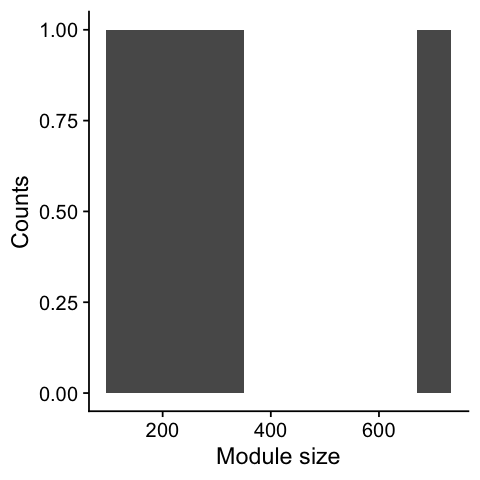

In [12]:
options(repr.plot.width=4, repr.plot.height=4)
module_size(gs)

Most of the clusters have small sizes (1,2 SNPs). However, it seems that small clusters have a similar association scores as bigger clusters, so I am inclined to think that bigger clusters are not picked despite being having lower association scores, but because they happen to connect high-score SNPs.

In [13]:
blur:::compute_mod_size(gs)

module,chr,size,C
<int>,<int>,<int>,<dbl>
1,3,690,5.843032
3,8,316,5.396481
2,5,258,9.333046
4,10,210,5.429173
5,16,116,5.798756


It seems that the biggest clusters come from only 3 chromosomic regions in chromosomes 3, 5 and 8.

[1] TRUE

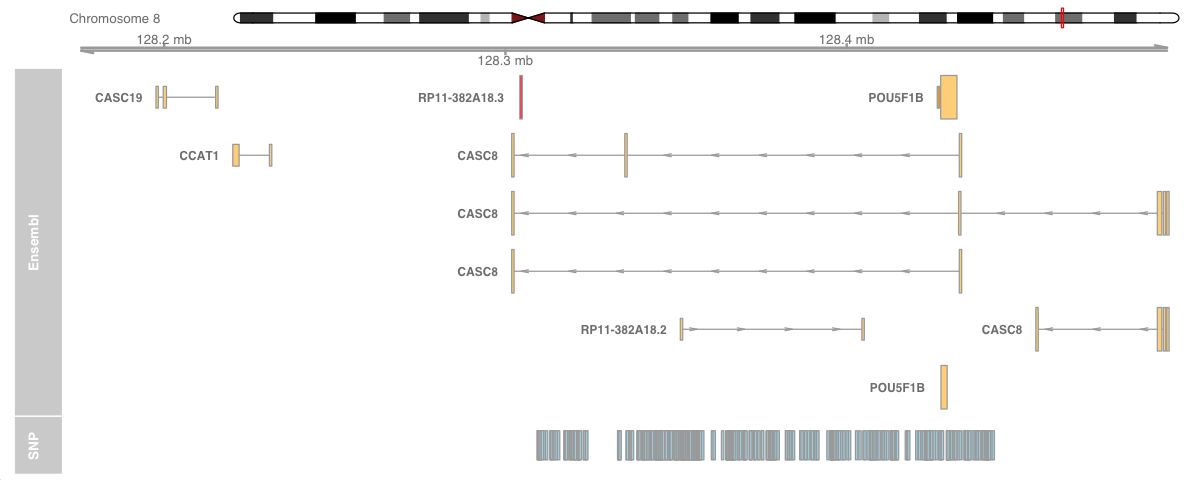

In [14]:
options(repr.plot.width=10, repr.plot.height=4)
# cluster in chromosome 8
plot_snp_module(gs, 3)

In chromosome 8 we find gene CASC8, which had appreared in previous analyses.

[1] TRUE

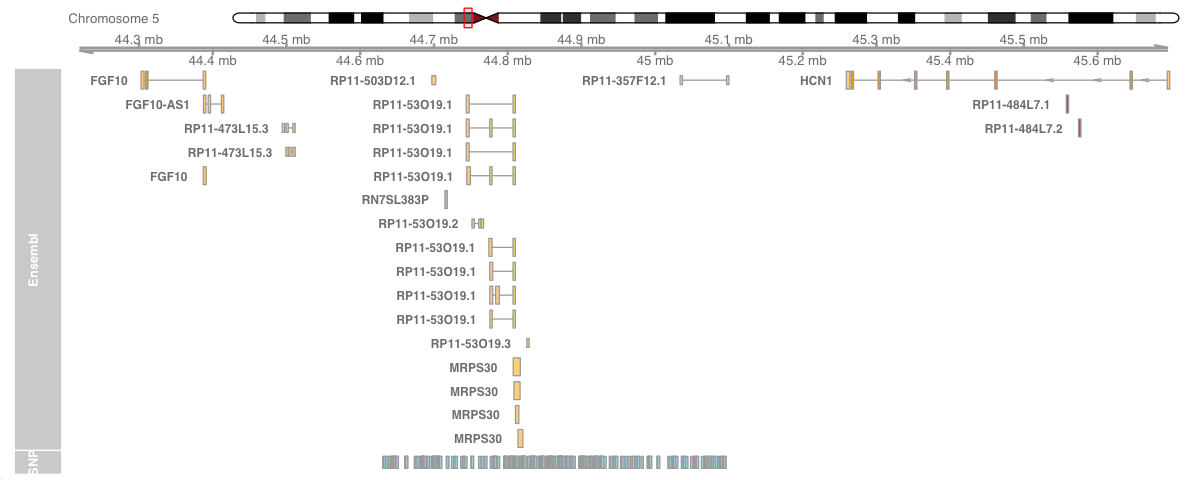

In [15]:
options(repr.plot.width=10, repr.plot.height=4)
# cluster in chromosome 5
plot_snp_module(gs, 2)

In this region we find two compelling genes: MRPS30, the S30 subunit of the mitochondrial ribosome and potentially involved in energetic metabolism; and, more interestingly, RP11-53O19.1, also known as Breast Cancer-Associated Transcript 54, a ncRNA.

[1] TRUE

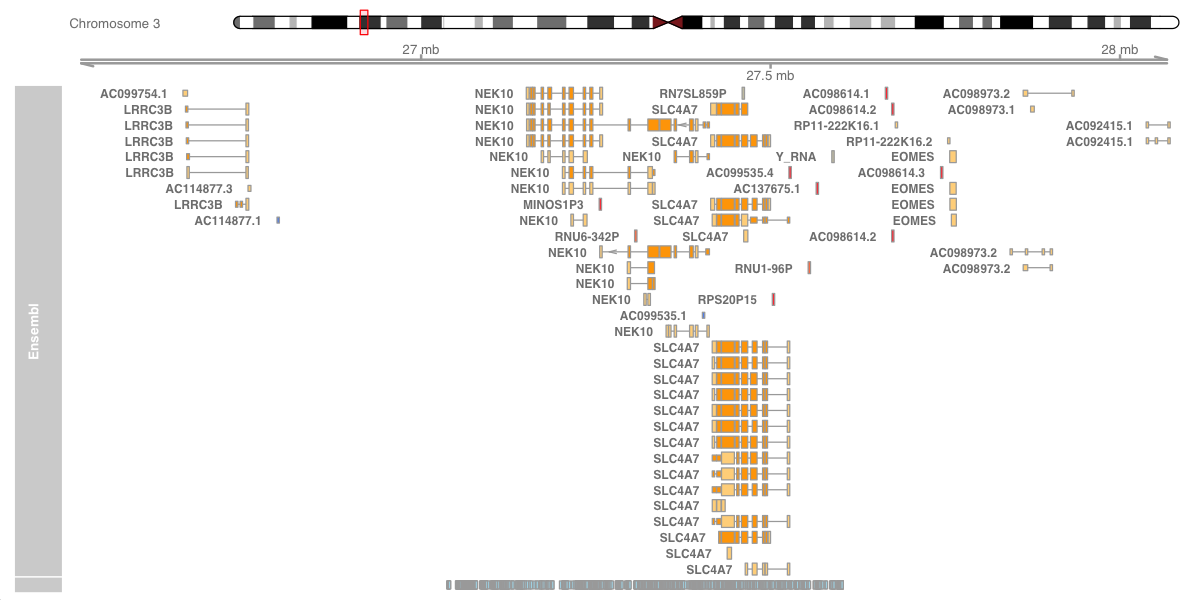

In [16]:
options(repr.plot.width=10, repr.plot.height=5)
k <- blur:::compute_mod_size(gs) %>% filter(chr == 3) %>% .$module %>% head(n = 20)
plot_snp_module(gs, k)

# GM network

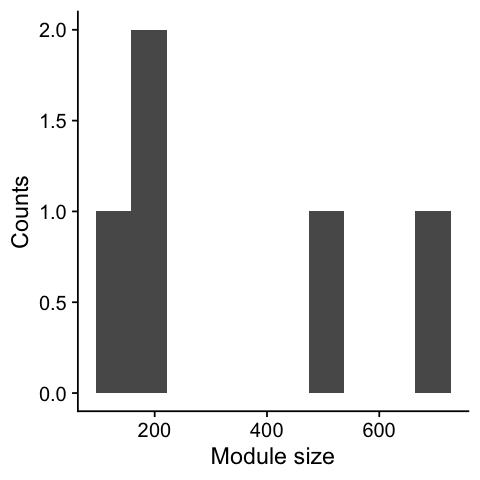

In [17]:
options(repr.plot.width=4, repr.plot.height=4)
module_size(gm)

In [18]:
blur:::compute_mod_size(gm)

module,chr,size,C
<int>,<int>,<int>,<dbl>
5,3,692,5.800495
3,5,481,3.905096
4,10,209,3.419875
2,16,187,5.011463
1,10,123,2.951184


Only 2 chromosomic regions here, in chromosomes 3 and 5, around the regions we already described.

[1] TRUE

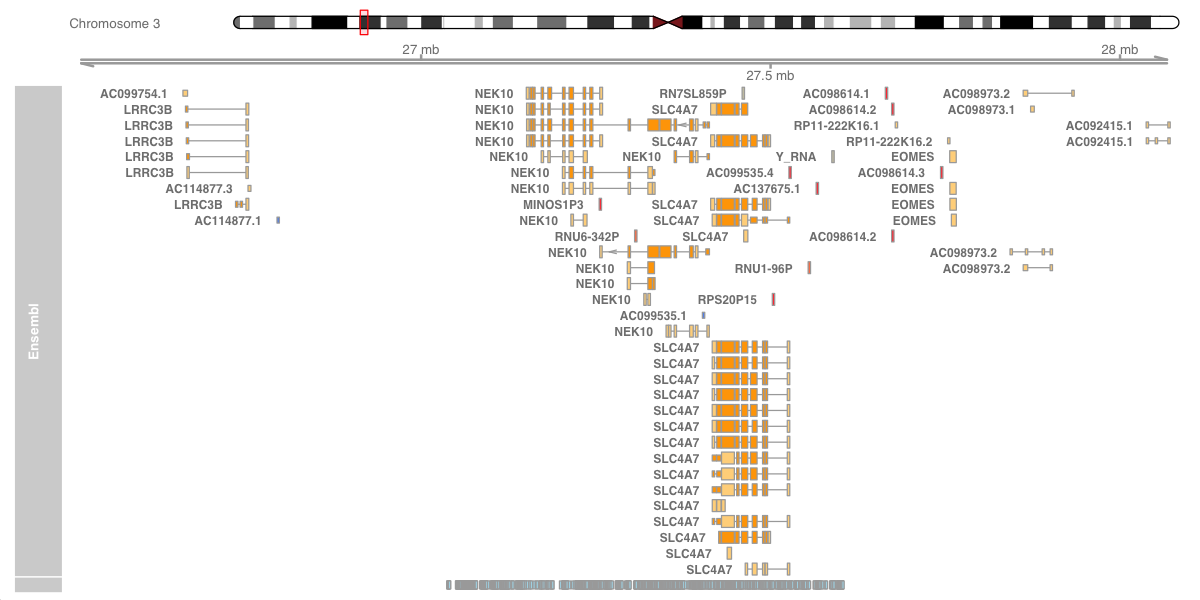

In [19]:
options(repr.plot.width=10, repr.plot.height=5)
k <- blur:::compute_mod_size(gm) %>% filter(chr == 3) %>% .$module %>% head(n = 20)
plot_snp_module(gm, k)

[1] TRUE

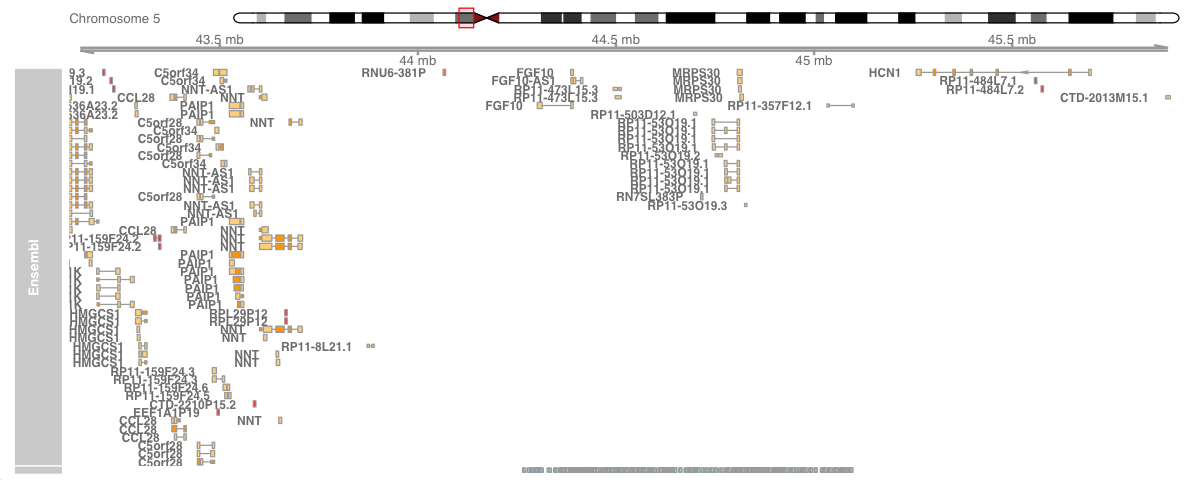

In [20]:
options(repr.plot.width=10, repr.plot.height=4)
k <- blur:::compute_mod_size(gm) %>% filter(chr == 5) %>% .$module %>% head(n = 20)
plot_snp_module(gm, k)

# GI network

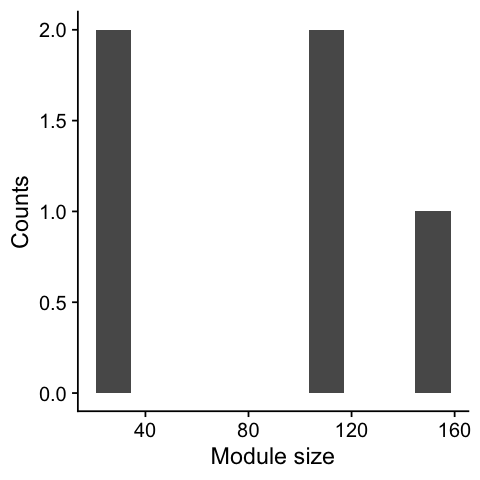

In [21]:
options(repr.plot.width=4, repr.plot.height=4)
module_size(gi)

In [22]:
head(blur:::compute_mod_size(gi))

module,chr,size,C
<int>,<int>,<int>,<dbl>
3,2,145,3.319429
5,5,111,6.269614
4,3,110,1.730752
1,4,21,7.709352
2,2,21,8.876349


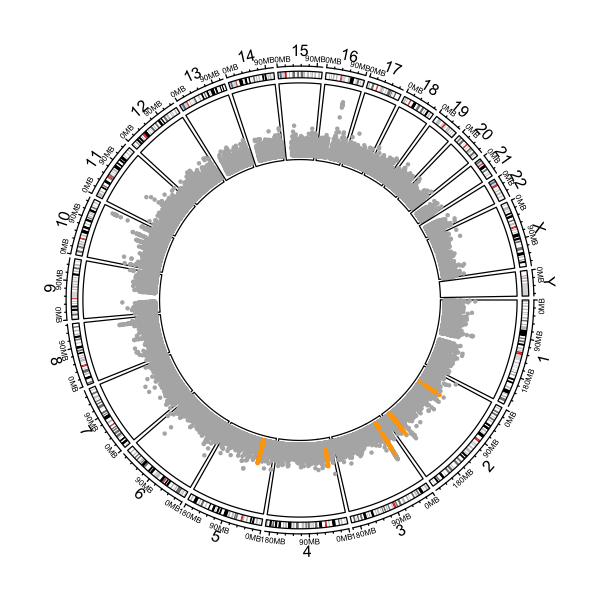

In [23]:
options(repr.plot.width=5, repr.plot.height=5)
plot_ideogram(gi)

We observe how modules span through different chromosomes.

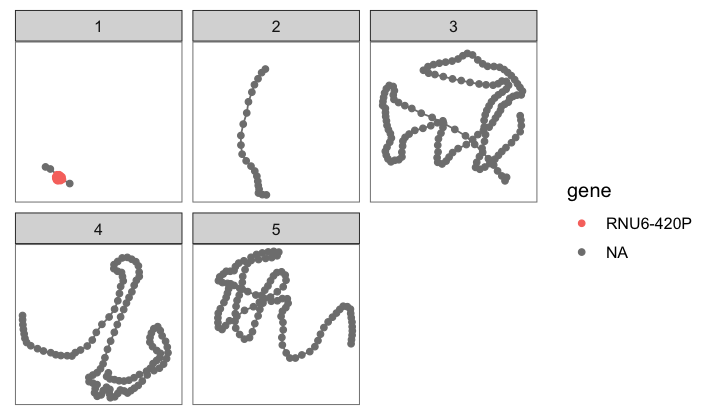

In [24]:
options(repr.plot.width=6, repr.plot.height=3.5)

filter(gi_net, selected) %>%
    igraph::as.igraph() %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = "grey50") +
        geom_nodes(aes(color = gene)) +
        facet_wrap(~module) +
        theme_facet()